In [1]:
# %matplotlib notebook
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
import torch.nn as nn
import pickle
import os

if torch.cuda.is_available():
    computing_device = torch.device("cuda")
else:
    computing_device = torch.device("cpu")

In [2]:
# # get paths to files

# # train_files = ['data/MT8_8K.wav']
# # train_files = ['data/02_8K.wav', 'data/03_8K.wav', 'data/04_8K.wav', 'data/05_8K.wav']
# # val_files = ['data/01_8K.wav']

# in_files=[]
# for root, dirs, files in os.walk("data/shijin"):
#     for file in files:
#         if file.endswith(".wav"):
#             in_files += [root + '/' + file]
# np.random.shuffle(in_files)

In [3]:
# import maestro
import pandas as pd
from sklearn.utils import shuffle 

maestro_root = "/imgne/maestro-v1.0.0/"

meta_df_orig = pd.read_csv(maestro_root + "maestro-v1.0.0.csv")
meta_df_orig["audio_filename"] = meta_df_orig["audio_filename"].apply(lambda x: maestro_root + x)
meta_df = meta_df_orig[meta_df_orig["year"] == 2017]

shuffle(meta_df)

train_files = meta_df[meta_df["split"] == "train"]["audio_filename"].values
val_files = meta_df[meta_df["split"] == "validation"]["audio_filename"].values
test_files = meta_df[meta_df["split"] == "test"]["audio_filename"].values[:1]

print(test_files[0])

/imgne/maestro-v1.0.0/2017/MIDI-Unprocessed_079_PIANO079_MID--AUDIO-split_07-09-17_Piano-e_1-04_wav--4.wav


In [4]:
from util import *

chunk_size = 20
window_size = 2046
window_overlap = 1023
batch_size = 8

test_data_file = "data/maestro2017_test.pkl"
# test_files = ['data/05_8K.wav']#, 'data/02_8K.wav', 'data/03_8K.wav', 'data/04_8K.wav', 'data/05_8K.wav']
# test_files = in_files

if os.path.exists(test_data_file): 
    test_gen = pickle.load(open(test_data_file, 'rb'))
else:
    test_gen = DataGenerator(test_files, chunk_size, window_size, window_overlap, batch_size)
    pickle.dump(test_gen, open(test_data_file, 'wb'))

In [5]:
# model setup

from lstm import *

input_dim = test_gen.X_list[0].shape[2] #TODO
hidden_dim = 2048
num_layers = 1

# model = LSTMBasic(input_dim, hidden_dim, num_layers=num_layers, batch_size=batch_size)
# model = LSTMFC(input_dim, hidden_dim, hidden_dim, num_layers=num_layers, batch_size=batch_size, dropout_p=0.2)
model = LSTMCNN(input_dim, hidden_dim, num_layers=num_layers, batch_size=batch_size, decoder="2fc")

model = model.to(computing_device)
criterion = nn.MSELoss().to(computing_device)
dp = nn.DataParallel(model, dim=1).to(computing_device)
m = dp.module
optimizer = torch.optim.Adam(dp.parameters(), lr=0.001)

In [6]:
# trainer setup

from lstm_trainer import *
trainer = LSTMTrainer(dp, criterion, optimizer)

Using cuda


In [14]:
# load trained model? 

load_model = True

if load_model:
    epochs_trained = 600
#     model_file = "models/cs{}_h{}_e{}.ckpt".format(chunk_size, hidden_dim, epochs_trained)
    model_file = "models/cs20_h2048_e{}.ckpt".format(epochs_trained)
    print("Loading model: {}".format(model_file))
    trainer.load_model(model_file, epochs_trained)

Loading model: models/cs20_h2048_e600.ckpt


# misc. tests below

In [8]:
raise Exception("STOP") # dirty way to stop the notebook

Exception: STOP

In [15]:
test_gen.randomize_idx()
fname, X, T = test_gen[0]
print(X.shape)

torch.Size([660, 8, 2048])


In [16]:
eval_output, hidden_states, cell_states = trainer.eval_model(test_gen, prime_len=100, gen_len=100, mode="constrained")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [17]:
eo = torch.FloatTensor(eval_output)[:, 0]
eo.shape

torch.Size([210, 8, 2048])

In [18]:
t,x = test_gen.reassemble_istft(eo[:, :1])

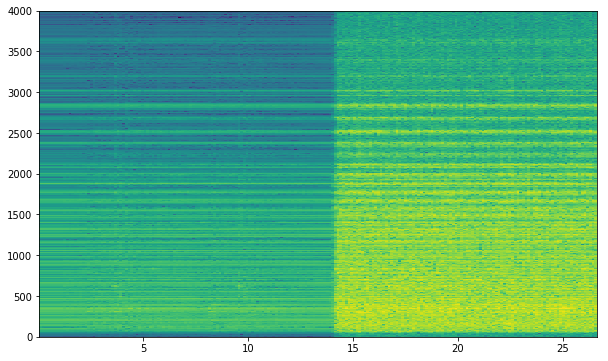

In [19]:
import matplotlib.pyplot as plt

fs = 8000

plt.figure(figsize=(10,6))
plt.specgram(x, Fs=fs, NFFT=window_size, noverlap=window_overlap)
plt.show()

In [20]:
from datetime import datetime
if not os.path.exists("./outputs"):
    os.makedirs("./outputs")
wavfile.write("outputs/{}.wav".format(datetime.now()), fs, x)

In [21]:
cell_states = np.array(cell_states)[:, 0, 0]
hidden_states = np.array(hidden_states)[:, 0, 0]

In [22]:
cell_states[:100].mean()

0.0014742585

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(eo[:,0].transpose(0,1), cmap='gray')
plt.show()
plt.figure(figsize=(15,15))
plt.imshow(cell_states.transpose(), cmap='gray')
plt.show()
X.max()

In [ ]:
train_losses = []
val_losses = []
for i in range(1,480):
    tl,vl = pickle.load(open("losses/cs20_h2048_e{}.loss.pkl".format(i), 'rb'))
    train_losses += [tl]
    val_losses += [vl]

In [ ]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

In [ ]:
plt.plot(train_losses.mean(axis=1)[10:])
plt.plot(val_losses.mean(axis=1)[10:])
plt.ylim(0, 0.0000030)
plt.show()